In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
REDUCTION = 'MONTGOMERY'
PROJ_DIR = '../../victim/simpleserial-kyber'
FIRMWAREPATH = '/home/toluntosun/Desktop/CW/chipwhisperer/hardware/victims/firmware'
NSHARES = 1
N = 100

In [2]:
import sys
sys.path.append('../../../scaredcu')

In [3]:
import scaredcu
import os
import cupy as cp
import numpy as np
from tqdm.auto import tqdm
import estraces
from xoflib import shake128
from matplotlib import pyplot as plt
%matplotlib widget

In [5]:
%%bash -s "$PROJ_DIR" "$FIRMWAREPATH" "$PLATFORM" "$REDUCTION" "$NSHARES"
cd $1
make FIRMWAREPATH=$2 PLATFORM=$3 REDUCTION=$4 NSHARES=$5

MONTGOMERY REDUCTION
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
MONTGOMERY REDUCTION
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
make[1]: '.dep' is up to date.
MONTGOMERY REDUCTION
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:12.2.rel1-1) 12.2.1 20221205
Copyright (C) 2022 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
-en     simpleserial-kyber.c ...
-e Done!
.
Compiling:
-en     src/cbd.c ...
-e Done!
.
Compiling:
-en     src/indcpa.c ...
-e Done!
.
Compiling:
-en     src/masked_indcpa.c ...
-e Done!
.
Compiling:
-en     src/masked_utils.c ...
-e Done!
.
Compiling:
-en     src/montgomery/ntt.c ...
-e Done!
.
Compiling:
-en     src/poly.c ...
-e Done!
.
Compiling:
-en     src/symmetric-fips202.c ...
-e Done!
.
Compiling:
-en     src/fips202.

../common/randombytes.c:38:2: warning: #warning Using a non-random randombytes [-Wcpp]
   38 | #warning Using a non-random randombytes
      |  ^~~~~~~


-e Done!
.
Compiling:
-en     /home/toluntosun/Desktop/CW/chipwhisperer/hardware/victims/firmware/simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     /home/toluntosun/Desktop/CW/chipwhisperer/hardware/victims/firmware/hal/stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     /home/toluntosun/Desktop/CW/chipwhisperer/hardware/victims/firmware/hal/stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     /home/toluntosun/Desktop/CW/chipwhisperer/hardware/victims/firmware/hal/stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Assembling: src/montgomery/fastbasemul.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mcpu=cortex-m4 -mfloat-abi=hard -mfpu=fpv4-sp-d16 -fmessage-length=0 -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=objdir-CWLITEARM/fastbasemul.lst -Isrc -I../common -Isrc/montgomery -I/home/toluntosun/Desktop/CW/chipwhisperer/hardware/victims/firmware/simpleserial/ -I/home/toluntosun/Desktop/CW/chipwhisperer/hardware/victims/firmware/hal

In [5]:
import chipwhisperer as cw
try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()

try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

scope.default_setup()

scope.adc.samples = 10000*NSHARES

print("INFO: Found ChipWhisperer😍")

/home/toluntosun/Desktop/CW/chipwhisperer/software/chipwhisperer/capture/trace/TraceWhisperer.py:31: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources # type: ignore
(ChipWhisperer NAEUSB WARNING|File naeusb.py:800) Your firmware (1.0) is outdated - latest is 1.62 See https://chipwhisperer.readthedocs.io/en/latest/firmware.html for more information


scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 98134                     to 5000                     
scope.adc.trig_count                     changed from 12285726                  to 26551011                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 3437633                   to 96000000                 
scope.clock.adc_rate                     changed from 3437633.0                 to 96000000.0               
scope.clock.clkgen_

In [6]:
fw_path = f'{PROJ_DIR}/simpleserial-kyber-{PLATFORM}.hex'
prog = cw.programmers.STM32FProgrammer
cw.program_target(scope, prog, fw_path)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 14399 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 14399 bytes


In [7]:
def coins_gen_s(coins):
    target.simpleserial_write('k',coins)
    sk_ = []
    
    for i in range(3):
        sk_.append(target.read(258))
    sk_ = bytes.fromhex(sk_[0][1:257] + sk_[1][1:257] + sk_[2][1:257])
    return scaredcu.lbc.kyber.decode_sk(sk_).get()

In [8]:
kyber_ntt = scaredcu.lbc.kyber.NTT()

def coins_to_c(coins):
    
    shake = shake128(coins)
    poly = scaredcu.lbc.kyber.kyber768_poly_unpack_decompress_du(shake.read(320))
    return kyber_ntt.ntt(poly, central_red=False).get()

In [9]:
coins = os.urandom(32)
print(coins)

s = coins_gen_s(coins)
print(kyber_ntt.ntt_inv(cp.array(s), central_red=True))

b'\x85\x07/\xc2\xeam\xfd\xfam\x1b\xeb\xce<C!\xe4\r\xd6\xc1\rmP(v\x81z\xbe\x16\xcc\xc88`'
[ 0  2 -1  0  0 -2 -2  1 -1  0  0  2  0  1 -1  0 -1  1  0  2  0 -1 -1  0
  1  0  0 -1  1  0  0  1  1  2 -1  1  0  0  0 -2  0  0 -1  1  1  0 -1  0
  1  0  0  1  0  2 -1  0 -1 -1  0  0  0  2  2  0  1 -1 -1 -1 -1  0 -1 -1
  0  1 -1  1 -1  0  1  1  1 -2  0  2  0  0  0  1  0  0  1  1  0 -1  0  1
 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1  1  0  0 -1 -2 -1  0  1 -2  1 -1 -1  0
  1  0  0  0  0  0 -1  0  0  1  2 -1  0  1 -2 -1  0 -2 -1  0 -1 -1  1 -1
  0  0 -2 -1  0  2 -2 -2  1 -1  0  1  0  1  0 -1  1 -1  1 -2  1 -1 -2  0
  0 -2  0  1  0  2  0  1  0  1  1  0  1  1 -1 -1  1  0 -1  1  0  0  1  1
  0 -1 -1  1  1  0 -1  0  1 -1  2 -2  0  0 -1  1 -1  0  1  1  0  0 -1  1
  2  0  0  1  0 -1  0 -1  0  1  0  0  2  0  1  0  0  0  0 -2  0  1  1  2
 -1  0  2  1  1  1  0  1  1  1 -1  1  1  1  0  0]


In [10]:
target.simpleserial_write('q', bytes())
target.simpleserial_wait_ack()

0

In [11]:
#Capture Traces

for i in range(1000):
    filename = f'traces/kyber_basemult_{REDUCTION.lower()}_d{NSHARES}_t{i}.ets'
    if os.path.isfile(filename):
        continue
    es_writer = estraces.ETSWriter(filename=filename, overwrite=False)
    break

target.output_len = 0


for i in tqdm(range(N)):
    coins = os.urandom(32)
    trace = cw.capture_trace(scope, target, cw.bytearray(coins))
    if trace is None:
        continue
    es_writer.write_samples(trace.wave)
    es_writer.write_metadata('c', coins_to_c(coins))
    es_writer.write_metadata('s', s)
    
es_writer.close()

  0%|          | 0/100 [00:00<?, ?it/s]

ERROR:estraces.formats.ets_writer:Exception raised during init of h5f file: [Errno 2] Unable to synchronously open file (unable to open file: name = 'traces/kyber_basemult_montgomery_d1_t4.ets', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0).


In [12]:
filename

'traces/kyber_basemult_montgomery_d1_t4.ets'

In [13]:
ths = estraces.read_ths_from_ets_file(filename)

print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file traces/kyber_basemult_montgomery_d1_t4.ets with 100 traces.
c................: uint16
s................: uint16



/home/toluntosun/miniconda3/envs/sca/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


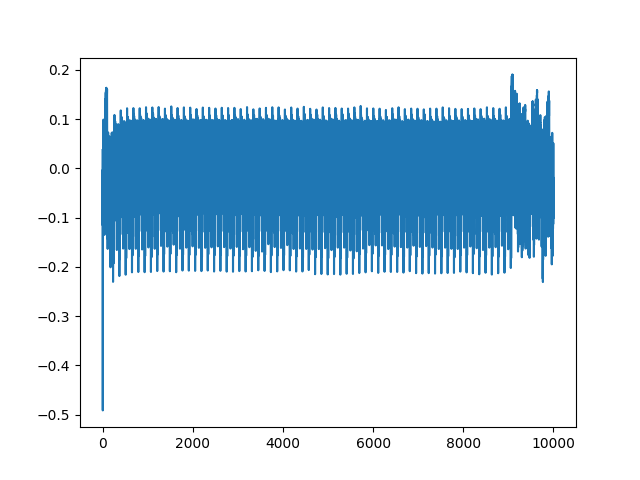

In [14]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

mean = ths.samples.mean(axis=0)

ax.plot(mean)